In [5]:
#%matplotlib inline
import csv
import math
import random
from matplotlib import pyplot as plt

In [6]:
def retrieveData():
    data = list(csv.reader(open('test1.csv')))
    for i in data:
        i[0] = float(i[0])
        i[1] = float(i[1])
    lattitude = [i[0] for i in data]
    longitude = [i[1] for i in data]
    coordinates = [[lattitude[i], longitude[i]] for i in range(len(data))]
    places = [i[2] for i in data]
    return coordinates, places

def retrievePreviousData():
    data = list(csv.reader(open('prevTour.csv')))
    return data



In [7]:
class ACO:
    class Edge:
        def __init__(self, a, b, weight, initial_pheromone):
            self.a = a
            self.b = b
            self.weight = weight
            self.pheromone = initial_pheromone

    class Ant:
        def __init__(self, alpha, beta, num_nodes, edges):
            self.alpha = alpha
            self.beta = beta
            self.num_nodes = num_nodes
            self.edges = edges
            self.tour = None
            self.distance = 0.0

        def _select_node(self):
            unvisited_nodes = [node for node in range(self.num_nodes) if node not in self.tour]
            exploration = random.uniform(0.0,1.0)
            if exploration < 0.10: #randomly explore
                min = float("inf")
                for unvisited_node in unvisited_nodes:
                    if self.edges[self.tour[-1]][unvisited_node].weight < min:
                        min = self.edges[self.tour[-1]][unvisited_node].weight
                        min_node = unvisited_node
                explored_node = min_node
                return explored_node
            else:
                roulette_wheel = 0.0
                for unvisited_node in unvisited_nodes: 
                    roulette_wheel += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                      pow((1.0 / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
                random_value = random.uniform(0.0, 1.0)
                wheel_position = 0.0
                for unvisited_node in random.sample(unvisited_nodes,len(unvisited_nodes)):
                    wheel_position += (pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                      pow((1.0 / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)) / roulette_wheel
                    if wheel_position >= random_value:
                        return unvisited_node

        def find_tour(self):
            self.tour = [random.randint(0, self.num_nodes - 1)]
            while len(self.tour) < self.num_nodes:
                self.tour.append(self._select_node())
            return self.tour

        def get_distance(self):
            self.distance = 0.0
            for i in range(self.num_nodes):
                self.distance += self.edges[self.tour[i]][self.tour[(i + 1) % self.num_nodes]].weight
            return self.distance

    def __init__(self, mode='Ant Colony System', colony_size=10, elitist_weight=1.0, min_scaling_factor=0.001, alpha=1.0, beta=3.0,
                 rho=0.1, pheromone_deposit_weight=1.0, initial_pheromone=1.0, jump_pheromone=1.5, steps=100, nodes=None, labels=None, previous_path=None):
        self.mode = mode
        self.colony_size = colony_size
        self.elitist_weight = elitist_weight
        self.min_scaling_factor = min_scaling_factor
        self.rho = rho
        self.pheromone_deposit_weight = pheromone_deposit_weight
        self.steps = steps
        self.num_nodes = len(nodes)
        self.nodes = nodes
        if labels is not None:
            self.labels = labels
        else:
            self.labels = range(1, self.num_nodes + 1)
        self.edges = [[None] * self.num_nodes for _ in range(self.num_nodes)]
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                self.edges[i][j] = self.edges[j][i] = self.Edge(i, j, math.sqrt(
                    pow(self.nodes[i][0] - self.nodes[j][0], 2.0) + pow(self.nodes[i][1] - self.nodes[j][1], 2.0)),
                                                                initial_pheromone)
        if previous_path != None:
            for i in range(len(previous_path)):
                if (previous_path[i-1] in labels) and (previous_path[i] in labels):
                    for j in range(len(labels)): #find index-1
                        if previous_path[i-1] == labels[j]:
                            for k in range(len(labels)):#find index-2
                                if previous_path[i] == labels[k]:
                                    self.edges[j][k].pheromone = jump_pheromone
                                    self.edges[k][j].pheromone = jump_pheromone
        
        self.ants = [self.Ant(alpha, beta, self.num_nodes, self.edges) for _ in range(self.colony_size)]
        self.global_best_tour = None
        self.global_best_distance = float("inf")

    def _add_pheromone(self, tour, distance, weight=1.0):
        pheromone_to_add = self.pheromone_deposit_weight / distance
        for i in range(self.num_nodes):
            self.edges[tour[i]][tour[(i + 1) % self.num_nodes]].pheromone += weight * pheromone_to_add

    def _elitist_acs(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            self._add_pheromone(self.global_best_tour, self.global_best_distance, weight=self.elitist_weight)
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)
                    
    def run(self):
        self._elitist_acs()
        print('Route Sequence: {0} '.format(','.join(str(self.labels[i]) for i in self.global_best_tour)))
        csv_str = [self.labels[i] for i in self.global_best_tour]
        with open("prevTour.csv",'w') as resultFile:
            wr = csv.writer(resultFile, dialect='excel')
            wr.writerow(csv_str)
        print('\nDistance of tour: {0}\n'.format(round(self.global_best_distance, 2)))

    def sketch(self, line_width=1.5, point_radius=math.sqrt(2.5), annotation_size=15, dpi=120, save=True, name=None):
        img = plt.imread('ny-map.jpg')
        fig, ax = plt.subplots()
        ax.imshow(img, extent=[-455, 705, -455, 405])
        x = [self.nodes[i][0] for i in self.global_best_tour]
        x.append(x[0])
        y = [self.nodes[i][1] for i in self.global_best_tour]
        y.append(y[0])
        plt.plot(x, y, linewidth=line_width, color='blue')
        plt.scatter(x, y, s=math.pi * (point_radius ** 5.0), color='firebrick')
        plt.title(self.mode)
        for i in self.global_best_tour:
            plt.annotate(self.labels[i], self.nodes[i], size=annotation_size, color='navy')
        if save:
            if name is None:
                name = '{0}_tour.png'.format(self.mode)
            plt.savefig(name, dpi=dpi)
        plt.show()
        plt.gcf().clear()



Route Sequence:  F, [, T, c, Q, G, H, S, m, ~, W, l, |, ^, Y, o, A, b, q, \, J, n, K, {, i, N, O, I, L, w, v, U, x, j, R, a, `, p, _, P, z, D, ], e, u, r, X, }, V, Z, h, t, s, y, E, f, B, k, M, g, d, C 

Distance of tour: 5612.07



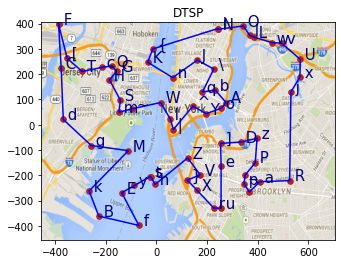

<Figure size 432x288 with 0 Axes>

In [8]:
if __name__ == '__main__':
    coordinates, places = retrieveData()
    previous_data = retrievePreviousData()
    _colony_size = 10
    _steps = 2000
    _nodes = coordinates
    elitist_instance = ACO(mode='DTSP', colony_size=_colony_size, steps=_steps, nodes=_nodes, labels=places, previous_path=previous_data)
    elitist_instance.run()
    elitist_instance.sketch()

In [9]:
import csv
data = list(csv.reader(open('datafile.csv')))
for i in data:
    i[0] = float(i[0])
    i[1] = float(i[1])
lattitude = [i[0] for i in data]
longitude = [i[1] for i in data]
coordinates = [[lattitude[i], longitude[i]] for i in range(len(data))]
places = [i[2] for i in data]
print (data)
print('lattitude: ', lattitude)
print('longitude: ', longitude)
print('coordinates: ', coordinates)
print('places: ', places)

[[300.0, 200.0, 'Office'], [-300.0, 150.0, 'Plant'], [-200.0, 300.0, 'Home'], [20.0, -350.0, 'Park'], [-25.0, 220.0, 'Garage'], [25.0, 84.0, 'Work'], [210.0, -97.0, 'Factory'], [215.0, 34.0, 'A'], [3.0, 45.0, 'B'], [-350.0, -350.0, 'C'], [78.8082523072, -277.584758819, ' a'], [-241.860995569, 240.378896381, ' b'], [323.343785709, 37.0648945699, ' c'], [36.304777219, -388.104545099, ' d'], [220.411659417, 89.4733712635, ' e']]
lattitude:  [300.0, -300.0, -200.0, 20.0, -25.0, 25.0, 210.0, 215.0, 3.0, -350.0, 78.8082523072, -241.860995569, 323.343785709, 36.304777219, 220.411659417]
longitude:  [200.0, 150.0, 300.0, -350.0, 220.0, 84.0, -97.0, 34.0, 45.0, -350.0, -277.584758819, 240.378896381, 37.0648945699, -388.104545099, 89.4733712635]
coordinates:  [[300.0, 200.0], [-300.0, 150.0], [-200.0, 300.0], [20.0, -350.0], [-25.0, 220.0], [25.0, 84.0], [210.0, -97.0], [215.0, 34.0], [3.0, 45.0], [-350.0, -350.0], [78.8082523072, -277.584758819], [-241.860995569, 240.378896381], [323.343785709,